In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/skin_cancer_dataset/ISBI2017_dataset/train/'
test_dir = '/content/drive/MyDrive/skin_cancer_dataset/ISBI2017_dataset/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

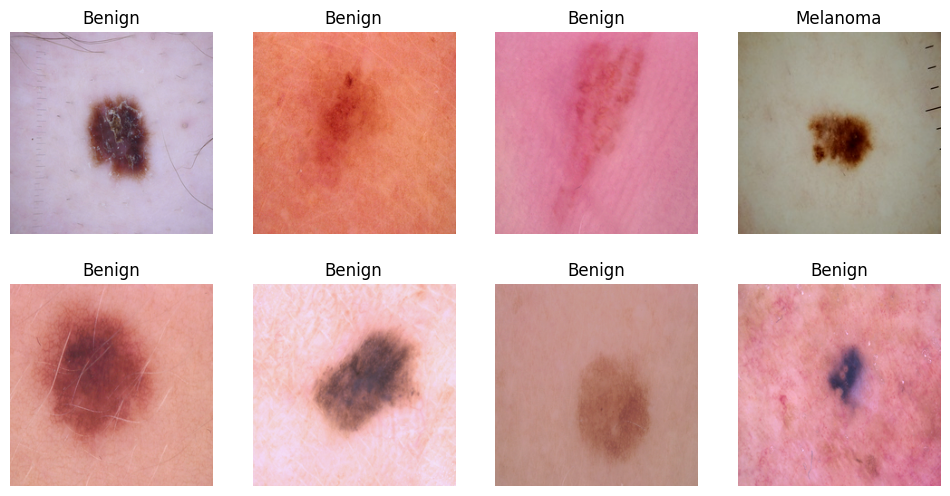

In [ ]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, DenseNet169, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [ ]:

# Define the base model from VGG16
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable except the last few
for layer in base_model.layers:
    layer.trainable = False
# Set the last VGG block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Define the input layer explicitly
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Add the VGG16 base model
x = base_model(input_layer)

# Add additional layers
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(len(unique_labels), activation='softmax')(x)

# Define the full model
model = Model(inputs=input_layer, outputs=output_layer)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 7,145,346 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

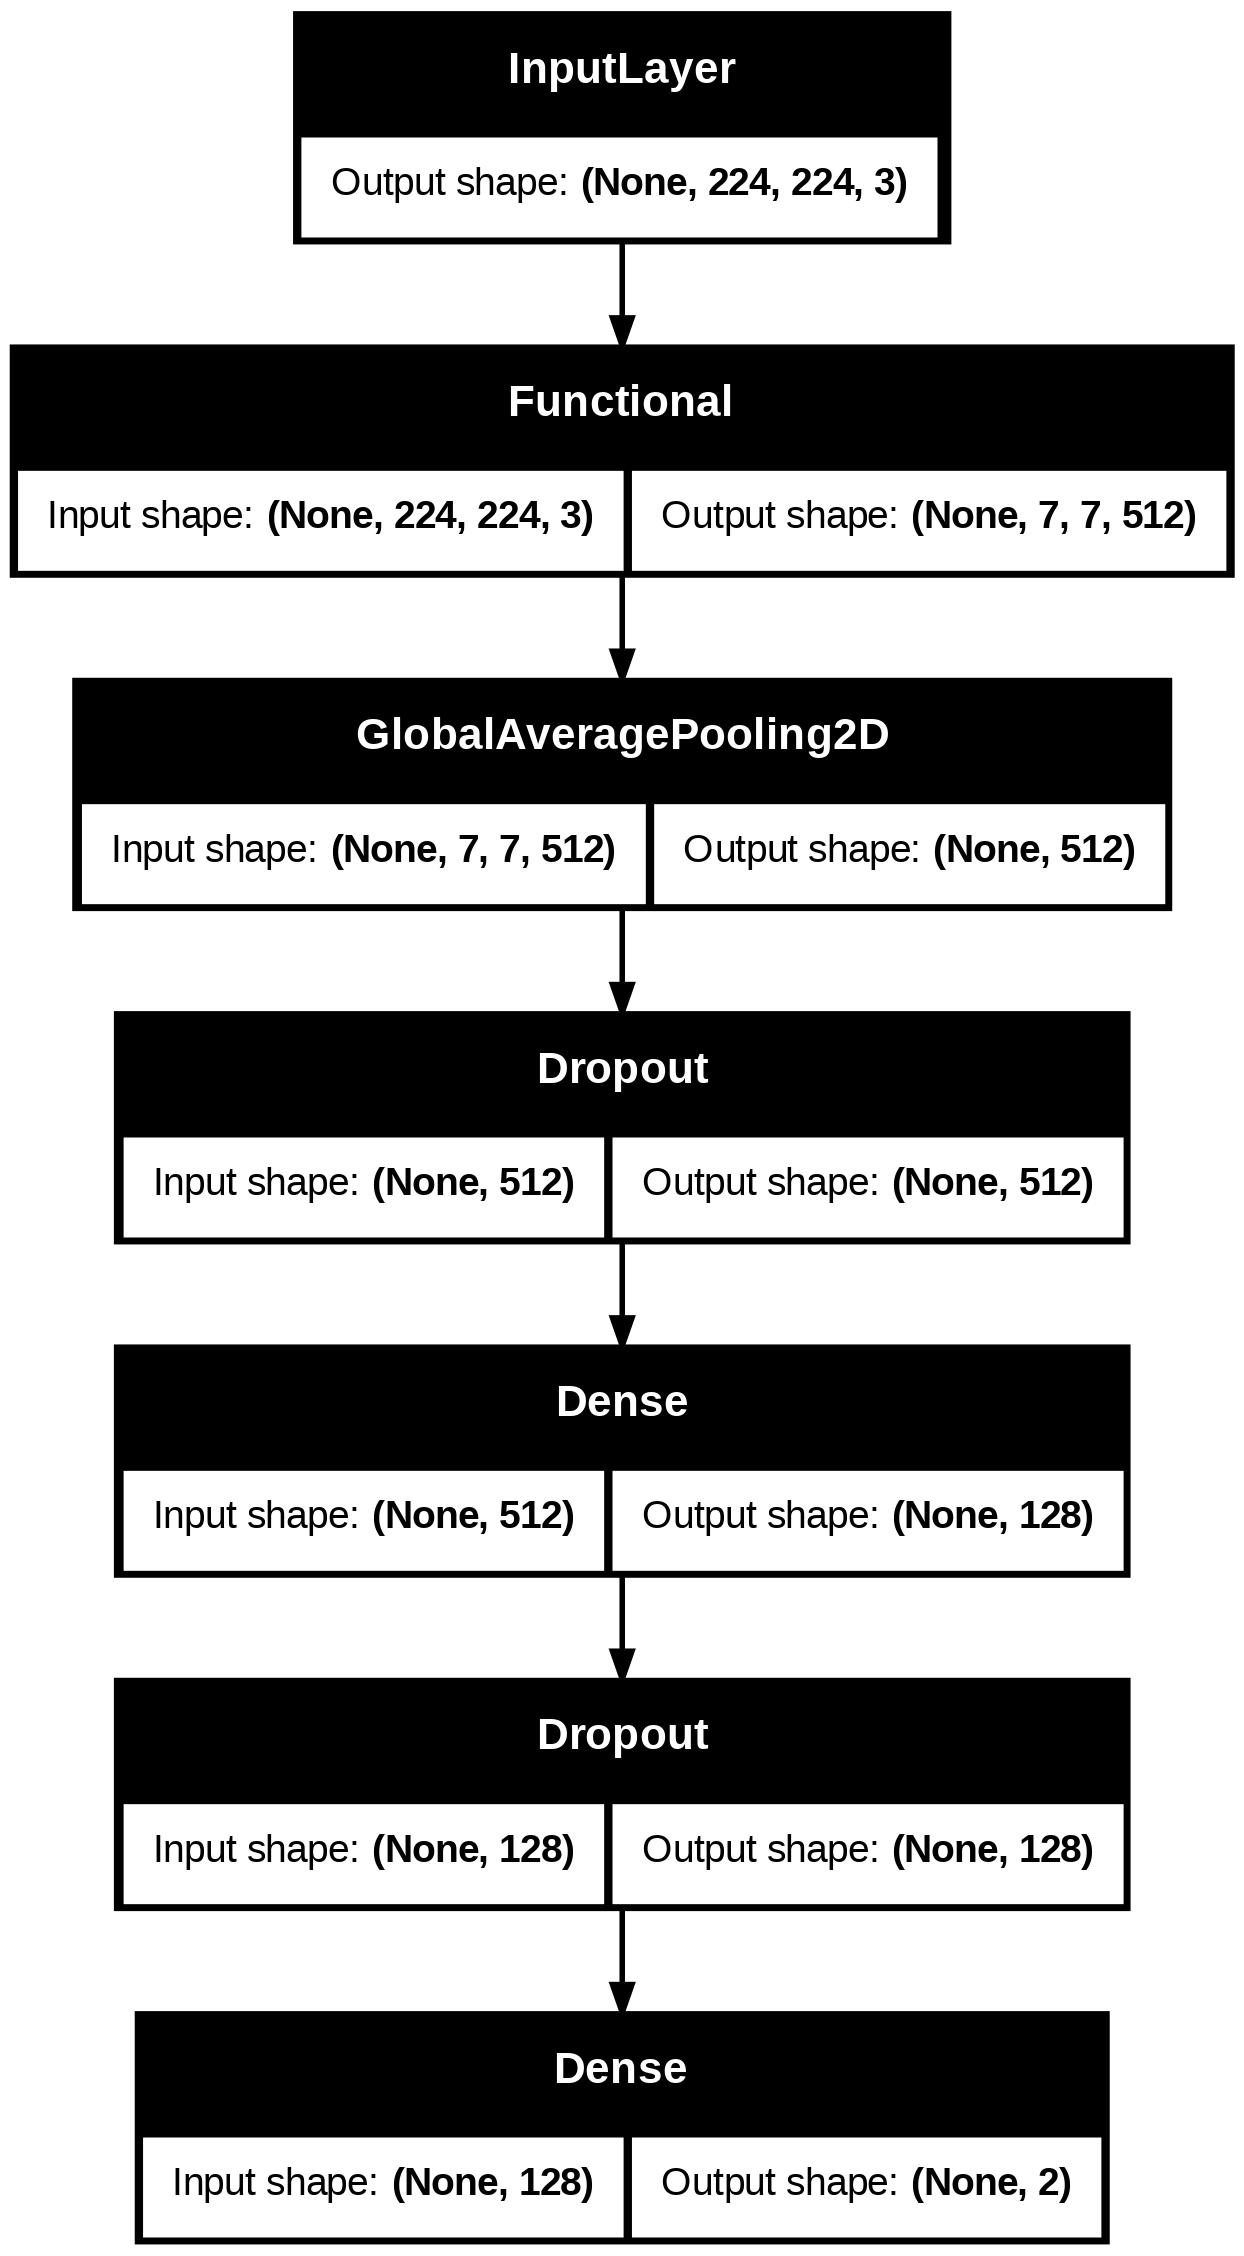

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 25
steps = int(len(train_paths)/batch_size)
epochs = 20
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 998s 14s/step - loss: 0.4350 - sparse_categorical_accuracy: 0.8189
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - loss: 0.1837 - sparse_categorical_accuracy: 0.9211
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - loss: 0.1062 - sparse_categorical_accuracy: 0.9559
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - loss: 0.0641 - sparse_categorical_accuracy: 0.9784
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - loss: 0.0456 - sparse_categorical_accuracy: 0.9867
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - loss: 0.0372 - sparse_categorical_accuracy: 0.9863
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - loss: 0.0462 - sparse_categorical_accuracy: 0.9871
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - loss: 0.0425 - sparse_categorical_accuracy: 0.9801
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - loss: 0.0400 - sparse_categorical_accuracy: 0.9901
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 200m

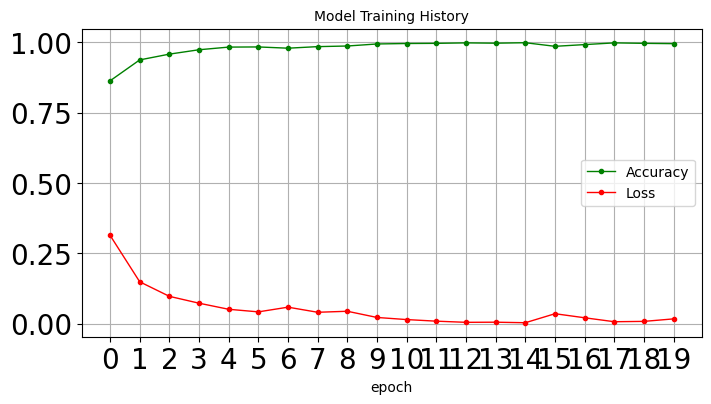

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=1)
plt.plot(history.history['loss'], '.r-', linewidth=1)
plt.title('Model Training History',fontsize =10)
plt.xlabel('epoch', fontsize =10)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='center right', fontsize =10)
plt.show()

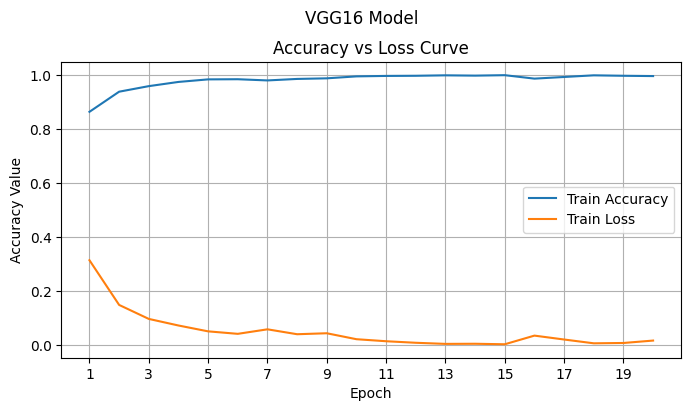

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')
f, ax1 = plt.subplots(figsize=(8, 4))
t = f.suptitle('VGG16 Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['sparse_categorical_accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['loss'], label='Train Loss')
ax1.grid()
ax1.set_xticks(np.arange(1, 21, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy vs Loss Curve')
l1 = ax1.legend(loc="best")

# Federated Learning Based transfer Learning enabled VGG16 Model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9762
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - loss: 0.0048 - sparse_categorical_accuracy: 1.0000
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - loss: 8.0582e-04 - sparse_categorical_accuracy: 0.9998
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - loss: 0.0050 - sparse_categorical_accuracy: 0.9982
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 7.8039e-04 - sparse_categorical_accuracy: 1.0000
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - loss: 0.0047 - sparse_categorical_accuracy: 0.9988
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - loss: 0.0034 - sparse_categorical_accuracy: 0.9998
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - loss: 0.0041 - sparse_categorical_accuracy: 0.9992
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - loss: 0.0156 - sparse_categorical_accuracy: 0.9945
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - los

  0%|          | 0/18 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


  6%|▌         | 1/18 [00:38<10:54, 38.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 11%|█         | 2/18 [00:58<07:24, 27.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 17%|█▋        | 3/18 [01:18<06:02, 24.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 22%|██▏       | 4/18 [01:38<05:11, 22.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 28%|██▊       | 5/18 [01:58<04:39, 21.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 33%|███▎      | 6/18 [02:16<04:07, 20.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 39%|███▉      | 7/18 [02:35<03:39, 19.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 44%|████▍     | 8/18 [02:55<03:18, 19.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 50%|█████     | 9/18 [03:14<02:57, 19.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 56%|█████▌    | 10/18 [03:33<02:36, 19.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 61%|██████    | 11/18 [03:52<02:14, 19.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 67%|██████▋   | 12/18 [04:10<01:52, 18.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 72%|███████▏  | 13/18 [04:28<01:34, 18.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 78%|███████▊  | 14/18 [04:47<01:15, 18.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 83%|████████▎ | 15/18 [05:06<00:56, 18.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 89%|████████▉ | 16/18 [05:25<00:37, 18.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 94%|█████████▍| 17/18 [05:44<00:18, 18.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


100%|██████████| 18/18 [06:03<00:00, 18.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


19it [06:37, 20.90s/it]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Benign       0.93      0.98      0.96       393
    Melanoma       0.97      0.86      0.91       207

    accuracy                           0.94       600
   macro avg       0.95      0.92      0.93       600
weighted avg       0.94      0.94      0.94       600



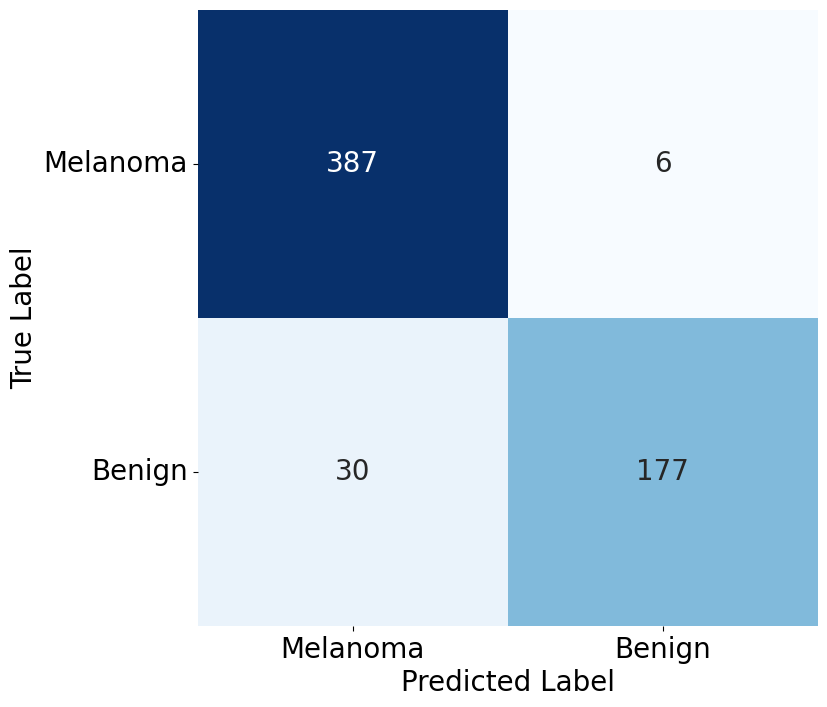

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()



In [ ]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 177.000000 TN: 387.000000 FP: 6.000000 FN: 30.000000


In [ ]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
acc=(TP+TN)/float(TN+FP+TP+FN)
print('acc: %.5f' % acc)
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)


acc: 0.94000
Specificity: 0.98473
 Recall: 0.85507
 Precision: 0.96721
F1 Score: 0.90769


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score

# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)

# Compute MCC
mcc_score = matthews_corrcoef(y_true, y_pred)

# Compute Cohen’s Kappa
kappa_score = cohen_kappa_score(y_true, y_pred)

# Print Metrics
print(f"AUC: {auc_score:.5f}")
print(f"MCC: {mcc_score:.5f}")
print(f"Cohen's Kappa: {kappa_score:.5f}")


AUC: 0.91990
MCC: 0.86709
Cohen's Kappa: 0.86350


In [1]:
import numpy as np
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score
TP=177
TN=387
FP=6
FN=30
# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)

# Compute MCC
mcc_score = matthews_corrcoef(y_true, y_pred)

# Compute Cohen’s Kappa
kappa_score = cohen_kappa_score(y_true, y_pred)

# Print Metrics
print(f"AUC: {auc_score:.5f}")
print(f"MCC: {mcc_score:.5f}")
print(f"Cohen's Kappa: {kappa_score:.5f}")


AUC: 0.91990
MCC: 0.86709
Cohen's Kappa: 0.86350


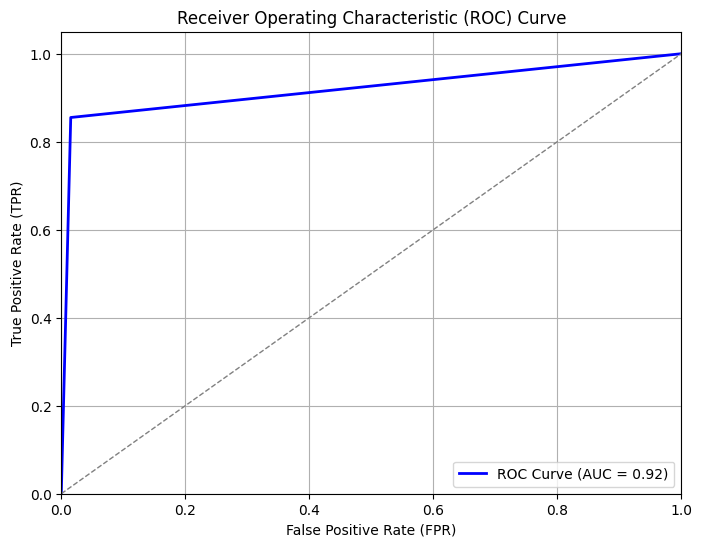

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()